### Load data set with features

In [1]:
from create_df import read_df
df, dfc, all_homes, appliance_min, national_average = read_df()

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
run all_functions.py

In [4]:
run features.py

In [5]:
import json

In [6]:
from sklearn.cross_validation import KFold


In [174]:
num_homes=10
total_homes = len(df.ix[all_homes['hvac']])
folds = np.ceil(total_homes*1./num_homes)
                  
kf = KFold(len(df.ix[all_homes['hvac']]), n_folds=folds, shuffle=True, random_state=2)
for train, test in kf:
    print sum(train), sum(test)

375 153
414 114
412 116
383 145


In [7]:
import sys

from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import KFold
from sklearn.cross_validation import ShuffleSplit

o = {}
for appliance in ["hvac"]:
    o[appliance] = {}
    appliance_df = df.ix[all_homes[appliance]]
    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop=1, 13
    for num_homes in [7, 12, 17, 22, 27]:
        print "NUM HOME", num_homes
        o[appliance][num_homes] = {}
        
        total_homes = len(appliance_df)
        
        
       
        
        for random_seed in range(20):
            o[appliance][num_homes][random_seed] = {}
            rs = ShuffleSplit(len(appliance_df), n_iter=5, train_size=num_homes, random_state=random_seed)

            for train, test in rs:
                train_homes = appliance_df.index.values[train]
                print train_homes
                test_homes = appliance_df.index.values[test]
                all_home_appliance = deepcopy(all_homes)
                all_home_appliance[appliance] = train_homes
                _, optimal_dict = find_optimal_features(df.ix[train_homes], dfc.ix[train_homes],
                                                            all_home_appliance, appliance_min, 
                                                            national_average, [appliance], 
                                                             {"All":feature_map["Monthly"]},
                                                              NUM_NEIGHBOURS_MAX=6, F_length_max=6, metric="mean",
                                                              train_outlier=True, test_outlier=False, outlier_features=None, outlier_fraction=0.1,
                                                              print_steps=False)
                f = optimal_dict[appliance]['All']['f']
                k = optimal_dict[appliance]['All']['k']
                for month in range(start, stop):   

                    print appliance, num_homes, random_seed, month
                    sys.stdout.flush()

                    clf = KNeighborsRegressor(n_neighbors=k)
                    clf.fit(df.ix[train_homes][f], df.ix[train_homes]['%s_%d' %(appliance, month)])
                    pred = pd.Series(clf.predict(df.ix[test_homes][f]), index=test_homes)
                    gt = df.ix[test_homes]['%s_%d' %(appliance, month)]
                    accur = 100-(pred-gt).abs().div(gt).mul(100)
                    accur[accur<0]=0
                    o[appliance][num_homes][random_seed][month]=accur.mean().mean()
                #o[appliance][num_homes] = pd.Series(o[appliance][num_homes][month]).mean()

            

NUM HOME 7
[ 410 6910 7731 4767 2242 9934 9654]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
hvac
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
********************
All
********************
1 ['difference_min_max', 'aggregate_12', 'aggregate_6'] 79.4727818244
--------------------------------------------------------------------------------
hvac 7 0 5
hvac 7 0 6
hvac 7 0 7
hvac 7 0 8
hvac 7 0 9
hvac 7 0 10
[4767 3367 9922 6910 6636 7731 3967]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
hvac
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
********************
All
********************
3 ['aggregate_4'] 83.9494414861
--------------------------------------------------------------------------------
hvac 7 0 5
hvac 7 0 6
hvac 7 0 7
hvac 7 0 8
hvac 7 0 9
hvac 7 0 10
[2156  370 7866 5357 1283 1953 4767]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
hvac
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
********************
All
********************
2 ['aggregate_8', 'aggregate_5'] 79.4738998987
----------------------------------

KeyboardInterrupt: 

In [241]:
import seaborn as sns

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


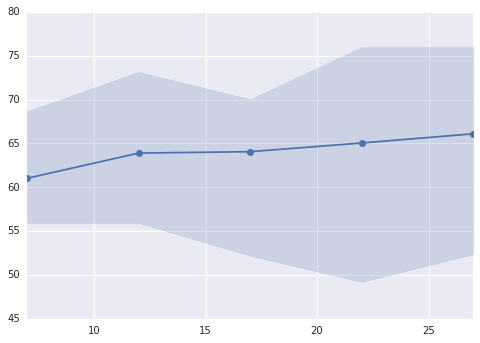

In [255]:
sns.tsplot(pd.DataFrame({k:pd.DataFrame(o['hvac'][k]).mean() for k in [7, 12, 17, 22, 27]}).values, 
           ci=95, time=[7, 12, 17, 22, 27], marker='o')

In [163]:
import sys

from sklearn.neighbors import KNeighborsRegressor
o = {}
for appliance in ["hvac","fridge","light","dw","dr","wm"]:
    o[appliance] = {}
    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop=1, 13
    for num_homes in [10]:
        o[appliance][num_homes] = {}
        for random_seed in range(10):
            o[appliance][num_homes][random_seed] = {}
            a,optimal_dict,train_homes = find_optimal_features_subset(df, dfc, all_homes, appliance_min, 
                                                                          national_average, [appliance], 
                                 {"All":feature_map["Monthly"]},
                              NUM_NEIGHBOURS_MAX=7, F_length_max=6, metric="mean",
                              train_outlier=True, test_outlier=False, outlier_features=None, outlier_fraction=0.1,
                              print_steps=False,random_seed=random_seed, num_homes=num_homes)
            f = optimal_dict[appliance]['All']['f']
            k = optimal_dict[appliance]['All']['k']
            for month in range(start, stop):   
                
                print appliance, num_homes, random_seed, month
                sys.stdout.flush()
                
                clf = KNeighborsRegressor(n_neighbors=k)
                clf.fit(df.ix[train_homes][f], df.ix[train_homes]['%s_%d' %(appliance, month)])
                test_homes = np.setdiff1d(all_homes[appliance], train_homes)
                pred = pd.Series(clf.predict(df.ix[test_homes][f]), index=test_homes)
                gt = df.ix[test_homes]['%s_%d' %(appliance, month)]
                accur = 100-(pred-gt).abs().div(gt).mul(100)
                accur[accur<0]=0
                o[appliance][num_homes][random_seed][month]=accur.mean().mean()
            o[appliance][num_homes][random_seed] = pd.Series(o[appliance][num_homes][random_seed][month]).mean()
        o[appliance][num_homes] = o[appliance][num_homes].values()
                
            

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
hvac
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
********************
All
********************
2 ['aggregate_8', 'aggregate_5', 'aggregate_11'] 80.0891783422
--------------------------------------------------------------------------------
hvac 10 0 5
hvac 10 0 6
hvac 10 0 7
hvac 10 0 8
hvac 10 0 9
hvac 10 0 10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
hvac
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
********************
All
********************
1 ['aggregate_6', 'aggregate_4'] 82.4589373494
--------------------------------------------------------------------------------
hvac 10 1 5
hvac 10 1 6
hvac 10 1 7
hvac 10 1 8
hvac 10 1 9
hvac 10 1 10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
hvac
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
********************
All
********************
2 ['aggregate_7', 'aggregate_12', 'aggregate_3'] 85.7272998467
--------------------------------------------------------------------------------
hvac 10 2 5
hvac 10 2 6
hvac 10 2 7
hva

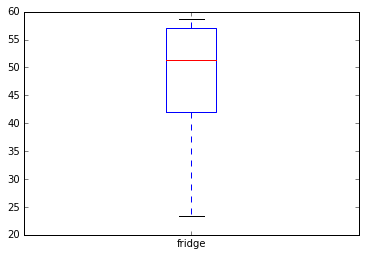

In [173]:
appliance="fridge"
pd.Series(o[appliance][10]).plot(kind="box",label=appliance)

In [127]:
o[appliance]

{10: {0: 64.048430850862133},
 15: {0: 59.832796095091076},
 20: {0: 64.752953520276307}}

In [120]:
o[appliance]

{10: {0: 64.650257340519772},
 15: {0: 59.832796095091076},
 20: {0: 70.596354522818601}}

In [118]:
o[appliance]

{10: {0: 56.181039909549369},
 11: {0: 53.839262737242692},
 15: {0: 57.109780976630304},
 20: {0: 51.969433707156547}}

In [125]:
len(feature_map["Monthly"])

15

In [55]:
output = {}
for appliance_name, appliance_results in out_appliance.iteritems():
    output[appliance_name] = pd.Series(appliance_results[0])
    tot = len(appliance_results)
    for i in range(1, tot):
        output[appliance_name] = output[appliance_name] + pd.Series(appliance_results[i])

output_df = pd.DataFrame(output)
output_df = output_df.div(tot)

In [2]:
#output_df.to_csv("sensitivity_num_homes.csv")
output_df = pd.read_csv("sensitivity_num_homes.csv", index_col=0)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
from common_functions import latexify, format_axes

In [5]:
latexify()

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [33]:
tableau20blind =  [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
  
# Rescale to values between 0 and 1
for i in range(len(tableau20blind)):  
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)
    
markers = ['o','^','*','v','.','d']

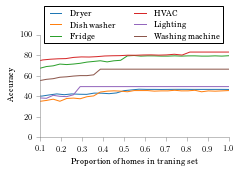

In [35]:
appliance_name_mapping = {"dr": "Dryer", "wm": "Washing machine",
                          "fridge":"Fridge","light":"Lighting",
                          "hvac":"HVAC","dw":"Dish washer"}

normalised_output = {}
fig, ax = plt.subplots(1,1)
for i, appliance_name in enumerate(output_df.columns):
    temp = output_df[appliance_name].dropna()
    temp.index= np.linspace(0, 1, len(output_df[appliance_name].dropna()))
    normalised_output[appliance_name] = temp
    pd.Series(normalised_output[appliance_name]).plot(ax=ax, label=appliance_name_mapping[appliance_name], 
                                                      color=tableau20blind[i*2])
plt.xlim((0.1,1.))
plt.ylim((0, 100))
plt.legend(loc='center left', bbox_to_anchor=(0, 1.1), ncol=2)
plt.xlabel("Proportion of homes in traning set")
plt.ylabel("Accuracy")
format_axes(plt.gca())
plt.tight_layout()
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/sensitivity_num_homes.png",bbox_inches="tight")
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/sensitivity_num_homes.pdf",bbox_inches="tight")

In [50]:
normalised_output_df = pd.DataFrame(normalised_output)